In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
TRAINING_SAMPLE = 9000
VALIDATE_SIZE = 0.2
RANDOM_SEED = 2022 
RATIO_TO_FRAUD = 15

Init Plugin
Init Graph Optimizer
Init Kernel


In [8]:
path = "/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/Maintenance/"
X = pd.read_csv(path+"predictive_maintenance.csv")
print("The data looks like :")
print(X.head())
print(X.columns)
print(len(X.columns))
print("Break down of the Normal and Failure rows")
count_classes = pd.value_counts(X['Target'], sort = True)
print(count_classes)

The data looks like :
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Proc

In [9]:
print(X['Failure Type'].value_counts())
print(len(X))

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
10000


In [10]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# ordinal encode categorical variable "Type"
ordinal_cols = ['Type']
X_ordinal = X[ordinal_cols]
X_ordinal = ordinal_encoder.fit_transform(X_ordinal)
X_ordinal = pd.DataFrame(X_ordinal, columns = ordinal_cols)
print(X_ordinal.head())
X.drop(ordinal_cols,axis=1,inplace=True)
X[ordinal_cols] = X_ordinal[ordinal_cols]
print(X.head())

   Type
0   2.0
1   1.0
2   1.0
3   1.0
4   1.0
   UDI Product ID  Air temperature [K]  Process temperature [K]  \
0    1     M14860                298.1                    308.6   
1    2     L47181                298.2                    308.7   
2    3     L47182                298.1                    308.5   
3    4     L47183                298.2                    308.6   
4    5     L47184                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3                3       0   No Failure   
2                    1498         49.4                5       0   No Failure   
3                    1433         39.5                7       0   No Failure   
4                    1408         40.0                9       0   No Failure   

   Type  
0   2.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  


In [11]:
# because there is "Traget", failure type is redundent
X.drop(['UDI','Product ID','Failure Type'], axis=1, inplace=True)
y = X['Target']
#X.drop(['Target'], axis=1, inplace=True)
print(X.head())
print(y.head())

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  Type  
0         42.8                0       0   2.0  
1         46.3                3       0   1.0  
2         49.4                5       0   1.0  
3         39.5                7       0   1.0  
4         40.0                9       0   1.0  
0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64


In [49]:
# Save the normal and anomaly in separate dataframe
normal_dataset = X[X.Target == 0] 
anomaly_dataset = X[X.Target == 1]
#print(normal_dataset, anomaly_dataset)
# shuffle our training set
clean = normal_dataset.sample(frac=1).reset_index(drop=True)
# training set: exlusively non-anomaly
X_train = clean.iloc[:TRAINING_SAMPLE].drop('Target', axis=1)
print(clean.iloc[TRAINING_SAMPLE:].shape, anomaly_dataset.sample(frac=1).shape)
# testing  set: the remaining non-anomaly + all the anomaly 
X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], anomaly_dataset.sample(frac=1)]).reset_index(drop=True)
X_test.Target

(661, 7) (339, 7)


0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: Target, Length: 1000, dtype: int64

In [50]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)
# manually splitting the labels from the test df
X_test_normal = X_test[X_test["Target"]==0]
X_test_anomaly = X_test[X_test["Target"]==1]
y_test = X_test.Target.values.astype(bool)
X_test = X_test.loc[:, ~X_test.columns.isin(['Target'])]
X_test_normal = X_test_normal.loc[:, ~X_test_normal.columns.isin(['Target'])]
X_test_anomaly = X_test_anomaly.loc[:, ~X_test_anomaly.columns.isin(['Target'])]
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
# get normalization parameters by fitting to the training data
pipeline.fit(X_train)
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)
print(f"""Shape of the datasets:
        training (rows, cols) = {X_train.shape}
        validate (rows, cols) = {X_validate.shape}
        holdout  (rows, cols) = {X_test.shape}""")
#print(y_test)

Shape of the datasets:
        training (rows, cols) = (7200, 6)
        validate (rows, cols) = (1800, 6)
        holdout  (rows, cols) = (1000, 6)


In [24]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')    
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-27 12:09:22.954648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 12:09:22.954802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
#Define the callbacks for checkpoints and early stopping
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_anomaly.h5",
                                        mode='min', monitor='val_loss',                                        
                                        verbose=0, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
#Compile the Autoencoder
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
#Train the Autoencoder
history = autoencoder.fit(X_train_transformed, X_train_transformed,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            validation_data=(X_validate_transformed, X_validate_transformed),
                            verbose=1,
                            callbacks=[cp, early_stop]
                            ).history 

2022-10-27 12:13:59.078769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-27 12:13:59.078986: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-27 12:13:59.253284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.1872

2022-10-27 12:14:03.070339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 4s 53ms/step - loss: 0.1793 - accuracy: 0.1872 - val_loss: 0.1074 - val_accuracy: 0.1978
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0681 - accuracy: 0.1890 - val_loss: 0.0407 - val_accuracy: 0.1989
Epoch 3/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0296 - accuracy: 0.1936 - val_loss: 0.0252 - val_accuracy: 0.2044
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0228 - accuracy: 0.2715 - val_loss: 0.0223 - val_accuracy: 0.2928
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0205 - accuracy: 0.3200 - val_loss: 0.0204 - val_accuracy: 0.3233
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0190 - accuracy: 0.3422 - val_loss: 0.0191 - val_accuracy: 0.3594
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0180 - accuracy: 0.3725 - val_loss: 0.0182 - val_accuracy: 0.3822
Epoch 8/100
29/29 

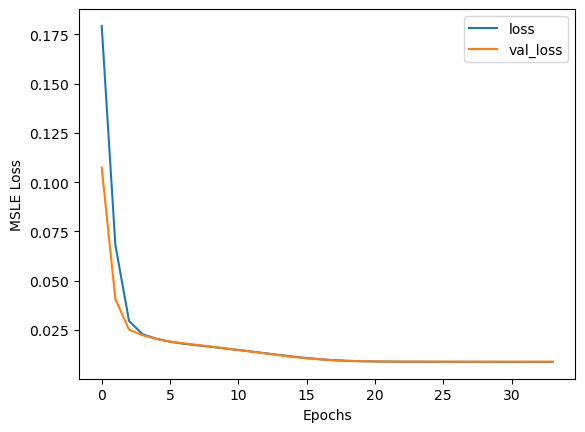

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


(1000, 6) (1000, 6) (1000,)


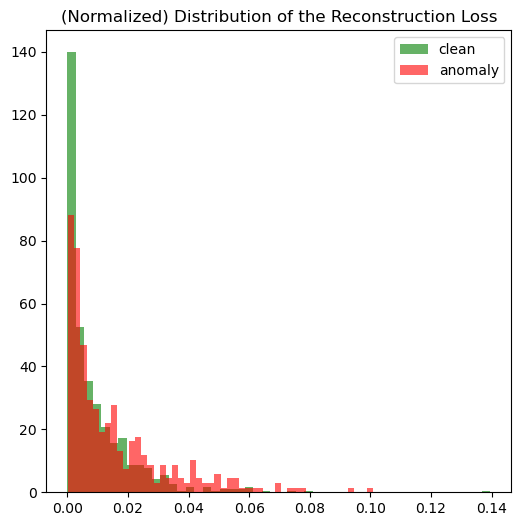

In [45]:
#Anomalies are data points where the reconstruction loss is higher
#To calculate the reconstruction loss on test data, predict the test data and calculate 
#the mean square error between the test data and the reconstructed test data.
X_test_transformed = pipeline.transform(X_test)
test_x_predictions = autoencoder.predict(X_test_transformed)
mse = np.mean(np.power(X_test_transformed - test_x_predictions, 2), axis=1)
print(X_test_transformed.shape, test_x_predictions.shape, mse.shape)
clean = mse[y_test==0]
anomaly = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(anomaly, bins=50, density=True, label="anomaly", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(
/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


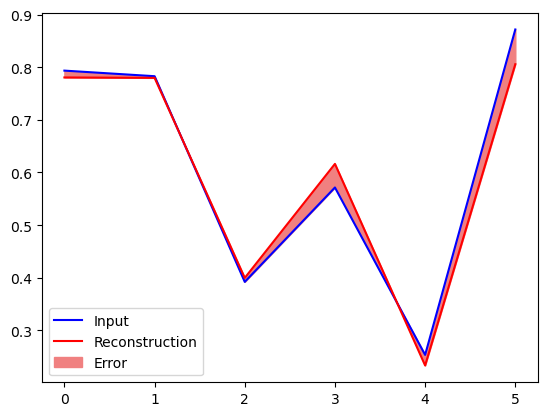

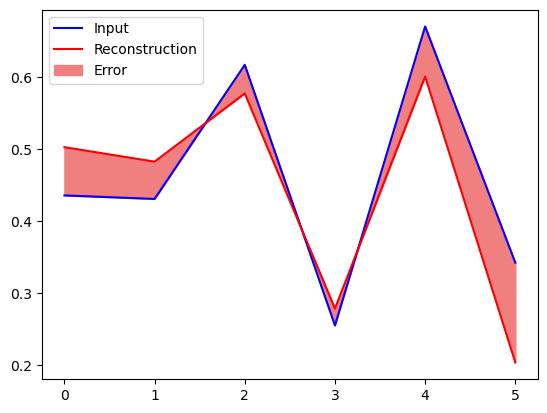

In [51]:
#define a function in order to plot the original data and reconstructed ones and also show the error
def plot(data, n):
    dec_img = autoencoder.predict(data)
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(6), data[n], dec_img[n], color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()
X_test_normal_transformed = pipeline.transform(X_test_normal.values)
X_test_anomaly_transformed = pipeline.transform(X_test_anomaly.values)
plot(X_test_anomaly_transformed, 0)
plot(X_test_normal_transformed, 0)

In [55]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
        + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = normal, 1 = anomaly
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    return preds

threshold = find_threshold(autoencoder, X_train_transformed)
print(f"Threshold: {threshold}")
predictions = get_predictions(autoencoder, X_test_transformed, threshold)
accuracy_score(predictions, y_test)

Threshold: 0.010391127144379762


0.661

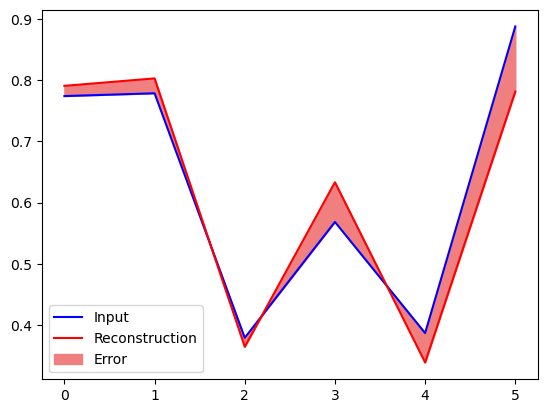

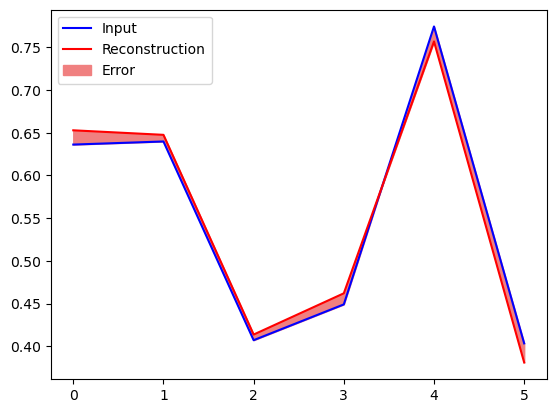

In [54]:
plot(X_test_transformed, 0)
plot(X_test_transformed, 4)

Percentiles: We could set this threshold by taking the top x% of the dataset and considering it anomalous. Remember
that total anomaly represents 0.0339 of total population.
MAD: We could also use a modified Z-score using the Median Absolute Deviation to define outliers on our reconstruction data. Here is a good blog post on the topic by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [61]:
# modified Z-scores with an absolute value of greater than 3.5 be labeled as potential outliers.
THRESHOLD = 2.0

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 182 outliers in a total of 1,000 transactions [18.20%].


In [62]:
from sklearn.metrics import precision_recall_curve

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:{cm}

% of test records labeled as anomaly that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of anomalous test records were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=2.0 are as follows:[[574  87]
 [244  95]]

% of test records labeled as anomaly that were correct (precision): 95/(87+95) = 52.20%
% of anomalous test records were caught succesfully (recall):    95/(244+95) = 28.02%
